In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Jan 28 20:09:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0   128W / 300W |   8265MiB / 80994MiB |     23%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1_1e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 255064
-rw-rw-r-- 1 scpark scpark   116053  1월 28 20:09 events.out.tfevents.1706440074.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7472764  1월 28 20:08 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 28 20:07 events.out.tfevents.1706439877.GPUSVR11
-rw-rw-r-- 1 scpark scpark 42894257  1월 28 20:01 events.out.tfevents.1706413004.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:48 save_280000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:33 save_270000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:18 save_260000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:02 save_250000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:47 save_240000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:31 save_230000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:16 save_220000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:01 save_210000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:45 save_200000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:30 save_190000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:14 save_

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

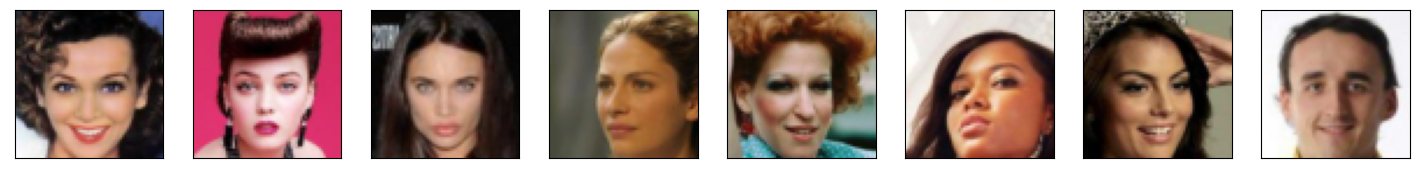

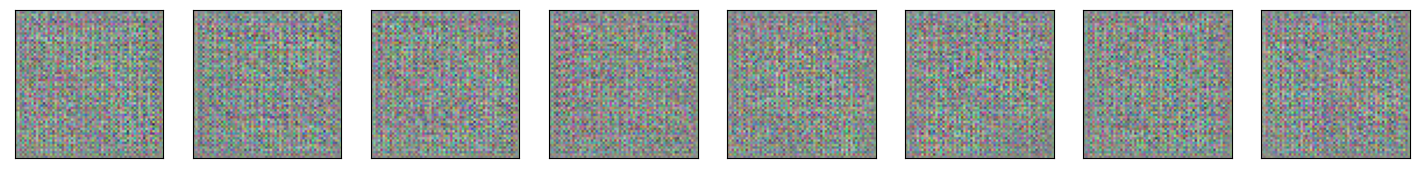

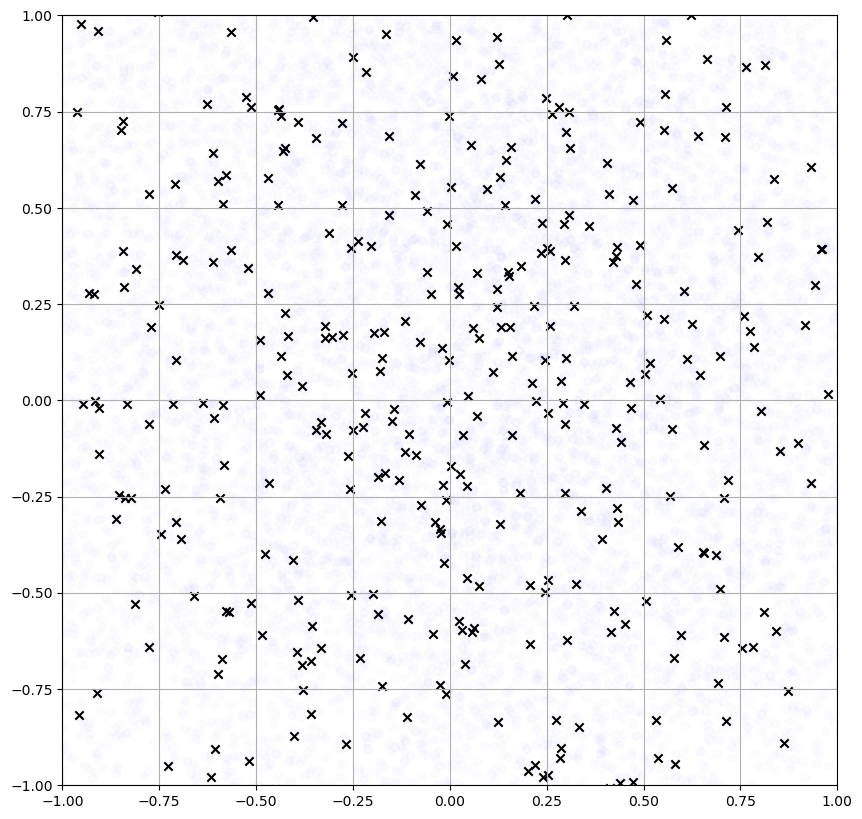

1
lse_loss 32.59568405151367
commit_loss 0.6407458782196045
recon_loss 0.11468827724456787
2
lse_loss 31.859596252441406
commit_loss 0.6286868453025818
recon_loss 0.10290133953094482
3
lse_loss 31.13962745666504
commit_loss 0.6133608818054199
recon_loss 0.10814319550991058
4
lse_loss 30.555072784423828
commit_loss 0.6029197573661804
recon_loss 0.1048603504896164
5
lse_loss 29.847171783447266
commit_loss 0.5886263847351074
recon_loss 0.0948006734251976
6
lse_loss 29.38025665283203
commit_loss 0.5775984525680542
recon_loss 0.10326095670461655
7
lse_loss 28.680831909179688
commit_loss 0.5646381378173828
recon_loss 0.09517911076545715
8
lse_loss 28.137903213500977
commit_loss 0.5533668994903564
recon_loss 0.08854752779006958
9
lse_loss 27.76318359375
commit_loss 0.5426952838897705
recon_loss 0.08728199452161789
10
lse_loss 26.511653900146484
commit_loss 0.5281325578689575
recon_loss 0.08325700461864471
11
lse_loss 26.196273803710938
commit_loss 0.5180863738059998
recon_loss 0.0861621350049

91
lse_loss 9.10454273223877
commit_loss 0.18895214796066284
recon_loss 0.035855982452631
92
lse_loss 9.086811065673828
commit_loss 0.18917840719223022
recon_loss 0.03384752199053764
93
lse_loss 9.074480056762695
commit_loss 0.18118107318878174
recon_loss 0.03173278644680977
94
lse_loss 9.1317138671875
commit_loss 0.18268337845802307
recon_loss 0.031023018062114716
95
lse_loss 9.213608741760254
commit_loss 0.1865922510623932
recon_loss 0.03370652347803116
96
lse_loss 9.078889846801758
commit_loss 0.17895853519439697
recon_loss 0.03121914342045784
97
lse_loss 8.967138290405273
commit_loss 0.17633549869060516
recon_loss 0.03228802606463432
98
lse_loss 9.139986991882324
commit_loss 0.18286114931106567
recon_loss 0.030076300725340843
99
lse_loss 9.053054809570312
commit_loss 0.1798182725906372
recon_loss 0.02937992475926876
100
lse_loss 9.195940017700195
commit_loss 0.1809474676847458
recon_loss 0.031431641429662704
101
lse_loss 9.043623924255371
commit_loss 0.18126721680164337
recon_loss 

lse_loss 9.731539726257324
commit_loss 0.14711908996105194
recon_loss 0.017832636833190918
180
lse_loss 9.693618774414062
commit_loss 0.14470836520195007
recon_loss 0.018787095323204994
181
lse_loss 9.674088478088379
commit_loss 0.1460130512714386
recon_loss 0.018491851165890694
182
lse_loss 9.672627449035645
commit_loss 0.14672577381134033
recon_loss 0.017232270911335945
183
lse_loss 9.609151840209961
commit_loss 0.14042890071868896
recon_loss 0.01680631935596466
184
lse_loss 9.719902038574219
commit_loss 0.1429423689842224
recon_loss 0.018139710649847984
185
lse_loss 9.657647132873535
commit_loss 0.13435298204421997
recon_loss 0.01590338908135891
186
lse_loss 9.689262390136719
commit_loss 0.13735933601856232
recon_loss 0.01686597615480423
187
lse_loss 9.856956481933594
commit_loss 0.13636073470115662
recon_loss 0.02056315541267395
188
lse_loss 9.859569549560547
commit_loss 0.14224573969841003
recon_loss 0.018520375713706017
189
lse_loss 9.90217113494873
commit_loss 0.1471027135848999

267
lse_loss 10.730823516845703
commit_loss 0.11965256929397583
recon_loss 0.011589553207159042
268
lse_loss 10.771364212036133
commit_loss 0.11986052244901657
recon_loss 0.011624647304415703
269
lse_loss 10.817036628723145
commit_loss 0.12303119897842407
recon_loss 0.010768657550215721
270
lse_loss 10.932845115661621
commit_loss 0.12389674782752991
recon_loss 0.012722275219857693
271
lse_loss 10.787696838378906
commit_loss 0.11837854236364365
recon_loss 0.011032933369278908
272
lse_loss 10.929088592529297
commit_loss 0.11770658195018768
recon_loss 0.010142538696527481
273
lse_loss 10.813065528869629
commit_loss 0.11953792721033096
recon_loss 0.010563326999545097
274
lse_loss 11.06113052368164
commit_loss 0.11634893715381622
recon_loss 0.013483554124832153
275
lse_loss 10.877313613891602
commit_loss 0.12575763463974
recon_loss 0.010521511547267437
276
lse_loss 10.85561752319336
commit_loss 0.11437330394983292
recon_loss 0.01015840657055378
277
lse_loss 11.007194519042969
commit_loss 0.

lse_loss 12.186867713928223
commit_loss 0.10867507755756378
recon_loss 0.008682827465236187
355
lse_loss 12.151285171508789
commit_loss 0.10583879053592682
recon_loss 0.008360497653484344
356
lse_loss 12.061258316040039
commit_loss 0.10373573005199432
recon_loss 0.008665543049573898
357
lse_loss 12.224395751953125
commit_loss 0.11041288077831268
recon_loss 0.007762211374938488
358
lse_loss 12.139554023742676
commit_loss 0.10380242019891739
recon_loss 0.008521217852830887
359
lse_loss 12.294031143188477
commit_loss 0.10773906111717224
recon_loss 0.008352353237569332
360
lse_loss 12.292661666870117
commit_loss 0.1142529547214508
recon_loss 0.00798703357577324
361
lse_loss 12.274178504943848
commit_loss 0.11322352290153503
recon_loss 0.008608756586909294
362
lse_loss 12.201750755310059
commit_loss 0.10347714275121689
recon_loss 0.008149592205882072
363
lse_loss 12.251777648925781
commit_loss 0.10356424748897552
recon_loss 0.008201041258871555
364
lse_loss 12.344094276428223
commit_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')